<a href="https://colab.research.google.com/github/aggelospsiris/Document-Classification-and-Information-Extraction/blob/main/graph_based_approach/gnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Graph-Based Inverted Index for Document Analysis with Enhanced Word Importance**

In [7]:
!pip install rank-bm25 networkx matplotlib nltk  node2vec

In [14]:
# Import necessary libraries
import json
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from rank_bm25 import BM25Okapi
from node2vec import Node2Vec  # Importing Node2Vec for generating node embeddings
import json
import re


# Download NLTK resources for text preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# Function to ensure all required packages are installed (optional, uncomment if needed)
# !pip install rank-bm25 networkx matplotlib nltk sklearn node2vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Data Loading and Preprocessing**(Tokenization,Lemmatization,Stopword Removal,English Word Filtering,Short Token Removal)

In [18]:
def load_and_preprocess_data(json_file_path):
    """
    Load data from the JSON file, preprocess each document's text, and return the preprocessed tokens.

    Args:
        json_file_path (str): Path to the JSON file containing the document data.

    Returns:
        List[List[str]]: A list of preprocessed token lists for each document.
    """
    # Load the JSON data
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    preprocessed_documents = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    english_words = set(words.words())  # Set of valid English words

    # Loop through each entry in the JSON data, concatenate relevant fields, and preprocess
    for entry in data['tables']:
        # Concatenate the title, abstract, and keywords fields (handle None values)
        combined_text = f"{entry.get('Title', '')} {entry.get('Abstract', '')} {entry.get('Keywords', '')}"

        # Convert text to lowercase and tokenize
        tokens = word_tokenize(combined_text.lower())

        # Remove stopwords, non-alphabetic tokens, lemmatize, keep only English words, and remove short tokens
        preprocessed_tokens = [
            lemmatizer.lemmatize(word)
            for word in tokens
            if word.isalpha() and word not in stop_words and len(word) > 1 and word in english_words
        ]

        # Add the preprocessed tokens to the list
        preprocessed_documents.append(preprocessed_tokens)

    return preprocessed_documents

# Load and preprocess data from the JSON file
json_file_path = './extracted_information.json'  # Replace with the actual file path
preprocessed_documents = load_and_preprocess_data(json_file_path)

# Display the first few preprocessed documents to check the output
for i, doc in enumerate(preprocessed_documents[:5]):
    print(f"Document {i+1}: {doc}")


Document 1: ['generating', 'hog', 'writer', 'retrieval', 'paper', 'pretraining', 'strategy', 'writer', 'retrieval', 'hog', 'input', 'image', 'application', 'segment', 'thing', 'technique', 'extract', 'handwriting', 'various', 'ending', 'training', 'vision', 'transformer', 'masked', 'handwriting', 'layer', 'trained', 'evaluation', 'approach', 'three', 'historical', 'ness', 'writer', 'retrieval', 'additionally', 'provide', 'ablation', 'architecture', 'evaluate', 'notably', 'related', 'work', 'map', 'margin', 'current', 'state', 'art', 'ing', 'robustness', 'data', 'competitive', 'even', 'small', 'achieve', 'accuracy', 'writer', 'retrieval', 'learning', 'masked', 'document', 'analysis']
Document 2: ['space', 'frequency', 'document', 'image', 'problem', 'document', 'analysis', 'computer', 'vision', 'although', 'far', 'one', 'main', 'task', 'ally', 'exhibit', 'acquisition', 'greatly', 'vary', 'throughout', 'page', 'nonetheless', 'even', 'dealing', 'local', 'patch', 'document', 'taking', 'acc

In [19]:
def build_bm25_inverted_index(preprocessed_documents):
    """
    Build an inverted index using BM25 for word importance based on preprocessed documents.

    Args:
        preprocessed_documents (List[List[str]]): A list of preprocessed token lists for each document.

    Returns:
        Dict[str, Dict]: An inverted index with words as keys and their BM25 importance scores and occurrences as values.
    """
    # Initialize the BM25 model with the preprocessed documents
    bm25 = BM25Okapi(preprocessed_documents)

    # Create the inverted index with BM25 scores
    inverted_index = defaultdict(lambda: {'importance': 0, 'occurrences': []})

    for doc_id, tokens in enumerate(preprocessed_documents):
        token_counts = defaultdict(int)
        for token in tokens:
            token_counts[token] += 1

        for token in token_counts:
            score = bm25.get_scores([token])[doc_id]
            inverted_index[token]['importance'] = max(inverted_index[token]['importance'], score)
            inverted_index[token]['occurrences'].append([doc_id, token_counts[token]])

    return inverted_index

# Use the preprocessed documents to build the inverted index
inverted_index = build_bm25_inverted_index(preprocessed_documents)

# Display a sample of the inverted index to verify its content
for word, data in list(inverted_index.items())[:5]:
    print(f"Word: {word}, Importance: {data['importance']}, Occurrences: {data['occurrences']}")

Word: generating, Importance: 3.4982337592254, Occurrences: [[0, 1], [11, 1], [33, 1], [50, 2], [65, 1], [71, 1], [72, 1], [82, 1], [101, 1], [108, 2], [120, 1], [131, 1]]
Word: hog, Importance: 7.215598031850992, Occurrences: [[0, 2]]
Word: writer, Importance: 7.476084964964416, Occurrences: [[0, 4], [62, 2], [112, 5]]
Word: retrieval, Importance: 4.202681230085463, Occurrences: [[0, 4], [8, 1], [19, 1], [41, 1], [42, 2], [54, 1], [56, 1], [71, 10], [81, 2], [82, 1], [84, 1], [93, 1], [97, 1], [112, 4], [124, 1], [127, 1], [129, 1]]
Word: paper, Importance: 0.1537274304646647, Occurrences: [[0, 1], [4, 1], [6, 1], [8, 1], [10, 1], [11, 1], [14, 1], [16, 2], [17, 1], [21, 1], [24, 1], [28, 1], [30, 1], [31, 1], [33, 1], [35, 1], [38, 1], [39, 1], [45, 1], [47, 1], [49, 1], [50, 1], [51, 1], [52, 1], [53, 2], [54, 1], [57, 1], [58, 1], [60, 1], [61, 1], [64, 1], [65, 1], [67, 1], [72, 1], [73, 1], [75, 1], [76, 1], [78, 1], [79, 1], [82, 1], [83, 1], [85, 1], [86, 1], [91, 1], [92, 1], 

**Built weighted texts graph from the inverted index**

In [35]:
import networkx as nx
import numpy as np
from collections import defaultdict
from typing import Dict, Set, Tuple

def build_graph_from_inverted_index(inverted_index: Dict[str, Dict], threshold_divisor: float = 2.0) -> nx.Graph:
    """
    Build a graph from the BM25 inverted index, with word and text nodes connected by weighted edges.

    Args:
        inverted_index (Dict[str, Dict]): Inverted index with words as keys and their importance scores and occurrences.
        threshold_divisor (float): Divisor to calculate the importance threshold for filtering low-importance words.

    Returns:
        nx.Graph: A graph with nodes representing texts and words, and edges representing relationships between them.
    """
    # Step 1: Extract word-doc relationships, word importance, and doc-words mapping from the inverted index
    word_docs = {word: {doc_id: count for doc_id, count in data['occurrences']} for word, data in inverted_index.items()}
    word_importance = {word: data['importance'] for word, data in inverted_index.items()}
    doc_words = defaultdict(dict)
    doc_ids = set()

    for word, occurrences in word_docs.items():
        for doc_id, count in occurrences.items():
            doc_words[doc_id][word] = count
            doc_ids.add(doc_id)

    # Step 2: Filter out low-importance words based on the threshold
    average_importance = np.mean(list(word_importance.values()))
    threshold = average_importance / threshold_divisor
    filtered_word_docs = {word: docs for word, docs in word_docs.items() if word_importance[word] >= threshold}
    filtered_word_importance = {word: importance for word, importance in word_importance.items() if importance >= threshold}
    filtered_doc_words = {doc_id: {word: tf for word, tf in words.items() if word in filtered_word_importance} for doc_id, words in doc_words.items()}

    # Step 3: Create the graph with text and word nodes, and add edges based on term frequencies and importance
    G = nx.Graph()

    # Add text nodes
    for doc_id in doc_ids:
        G.add_node(f'text_{doc_id}', type='text')

    # Add word nodes and edges with weights between words and texts
    for word, docs in filtered_word_docs.items():
        G.add_node(word, type='word')
        for doc_id, tf in docs.items():
            importance = filtered_word_importance[word]
            weight = importance * tf
            G.add_edge(word, f'text_{doc_id}', weight=weight)

    # Add edges between text nodes based on shared words
    for doc1 in doc_ids:
        for doc2 in doc_ids:
            if doc1 >= doc2:
                continue
            common_words = set(filtered_doc_words[doc1].keys()).intersection(set(filtered_doc_words[doc2].keys()))
            if not common_words:
                continue
            weight = sum((max(filtered_word_docs[word][doc2], filtered_word_docs[word][doc1]) * filtered_word_importance[word]) for word in common_words if word in filtered_word_docs)
            if weight > 0:
                G.add_edge(f'text_{doc1}', f'text_{doc2}', weight=weight)

    # Create the text subgraph
    text_nodes = [node for node in G.nodes if G.nodes[node]['type'] == 'text']
    text_subgraph = G.subgraph(text_nodes).copy()

    return text_subgraph

# Generate the graph using the inverted index
text_subgraph = build_graph_from_inverted_index(inverted_index, threshold_divisor=1)

# Display the number of edges in the created graph to get a sense of its complexity
print(f"Number of edges in the text subgraph: {text_subgraph.number_of_edges()}")


Number of edges in the text subgraph: 2330


**Generating Embeddings with node2vec**

In [41]:
def generate_text_embeddings_with_node2vec(text_subgraph: nx.Graph, embedding_size: int, walk_length: int, num_walks: int, window_size: int) -> Dict[str, np.ndarray]:
    """
    Generate embeddings for the text nodes in the provided graph using Node2Vec.

    Args:
        text_subgraph (nx.Graph): The graph with text nodes and edges.
        embedding_size (int): The size of the embeddings.
        walk_length (int): Length of each random walk.
        num_walks (int): Number of random walks to perform.
        window_size (int): Window size for the Word2Vec model.

    Returns:
        Dict[str, np.ndarray]: A dictionary with nodes as keys and their embeddings as values.
    """
    # Initialize Node2Vec with the text graph
    node2vec = Node2Vec(text_subgraph, dimensions=embedding_size, walk_length=walk_length, num_walks=num_walks, workers=1, p=1, q=2)

    # Train the Node2Vec model to generate embeddings
    model = node2vec.fit(window=window_size, min_count=1, sg=1)

    # Generate embeddings for each node
    embeddings = {node: model.wv[str(node)].tolist() for node in text_subgraph.nodes}

    return embeddings

# Example usage
embedding_size = 64
walk_length = 30
num_walks = 300
window_size = 5

# Generate the embeddings for the text nodes using Node2Vec
embeddings = generate_text_embeddings_with_node2vec(text_subgraph, embedding_size, walk_length, num_walks, window_size)

# Display a sample of the generated embeddings to verify the output
for node, embedding in list(embeddings.items())[:5]:
    print(f"Node: {node}, Embedding: {embedding[:5]}...")  # Displaying the first 5 values of the embedding for brevity


Computing transition probabilities:   0%|          | 0/148 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 300/300 [00:12<00:00, 23.92it/s]


Node: text_29, Embedding: [-0.04259924218058586, -0.3410365581512451, -0.048004090785980225, 0.12355296313762665, -0.16147233545780182]...
Node: text_52, Embedding: [0.15272580087184906, -0.37773415446281433, 0.22007699310779572, 0.002851411234587431, -0.11600545048713684]...
Node: text_55, Embedding: [0.15871895849704742, -0.09814140200614929, -0.0836591050028801, 0.31697744131088257, 0.19348159432411194]...
Node: text_122, Embedding: [0.19996009767055511, -0.025519050657749176, 0.5780838131904602, -0.25353026390075684, -0.017843276262283325]...
Node: text_7, Embedding: [0.3042954206466675, 0.045061592012643814, -0.1307028979063034, 0.2618996202945709, -0.32337528467178345]...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


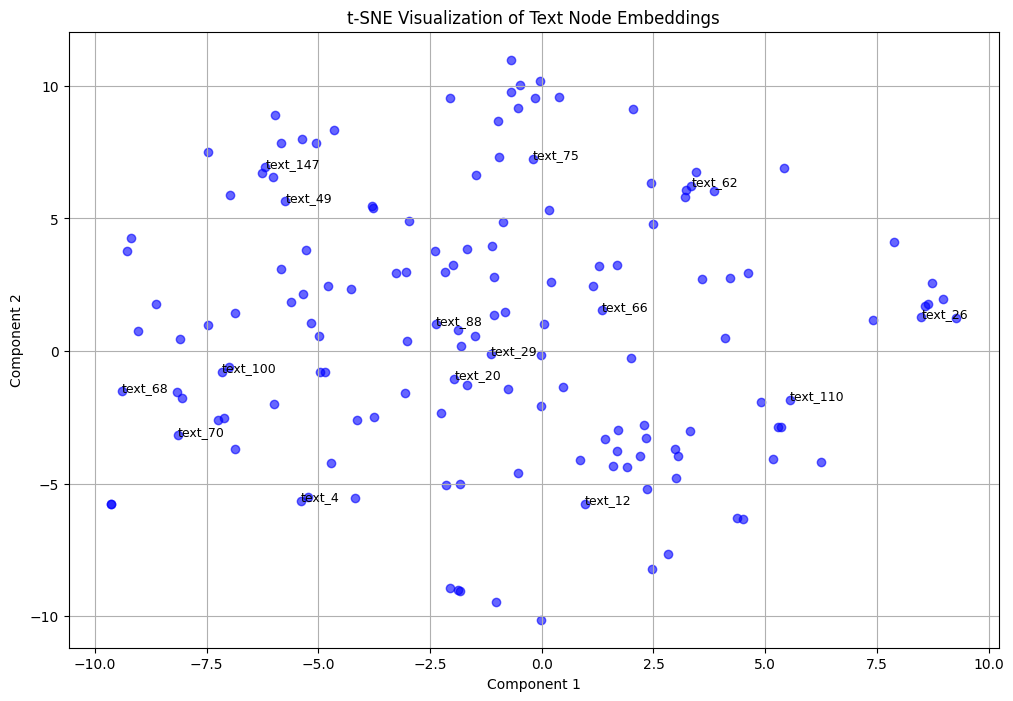

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings: Dict[str, np.ndarray], perplexity: int = 30, learning_rate: int = 200, n_iter: int = 1000):
    """
    Visualize the text embeddings using t-SNE.

    Args:
        embeddings (Dict[str, np.ndarray]): The text embeddings.
        perplexity (int): The perplexity parameter for t-SNE.
        learning_rate (int): The learning rate for t-SNE.
        n_iter (int): The number of iterations for t-SNE.
    """
    # Extract node names and their corresponding embeddings
    node_labels = list(embeddings.keys())
    embedding_vectors = np.array(list(embeddings.values()))

    # Perform t-SNE dimensionality reduction to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    reduced_embeddings = tsne.fit_transform(embedding_vectors)

    # Plot the embeddings using a scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o', alpha=0.6)

    # Annotate some points with their labels (optional)
    for i, label in enumerate(node_labels):
        if i % 10 == 0:  # Annotate every 10th point for readability
            plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)

    plt.title('t-SNE Visualization of Text Node Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# Visualize the generated embeddings using the function
visualize_embeddings(embeddings)



# **Clustering Using the Elbow Method**

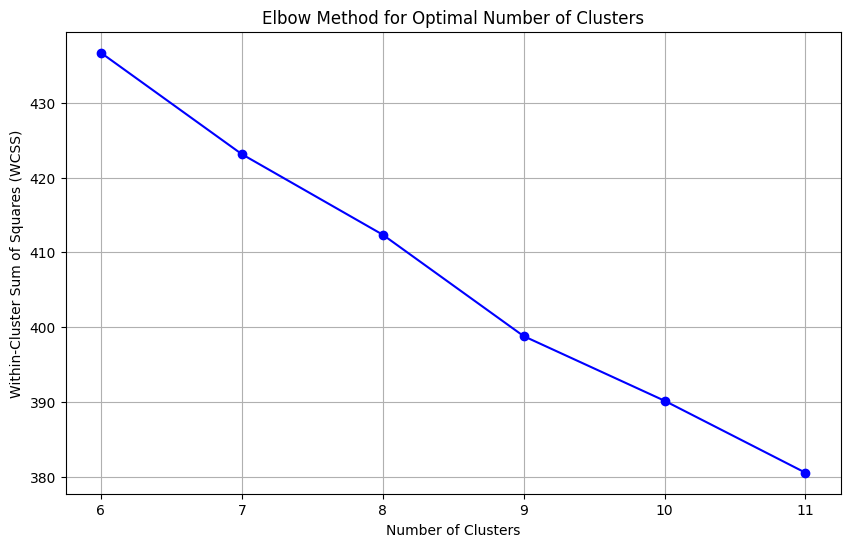

In [43]:
def find_optimal_clusters(embeddings, min_clusters=6, max_clusters=11):
    """
    Use the Elbow method to find the optimal number of clusters for K-means clustering.

    Args:
        embeddings (Dict[str, np.ndarray]): Dictionary of text node embeddings.
        min_clusters (int): Minimum number of clusters to evaluate.
        max_clusters (int): Maximum number of clusters to evaluate.

    Returns:
        None
    """
    # Convert embeddings to a list of vectors for clustering
    embedding_vectors = np.array(list(embeddings.values()))

    wcss = []  # List to store the within-cluster sum of squared errors

    # Perform K-means clustering for each number of clusters and compute WCSS
    for n_clusters in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(embedding_vectors)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow curve to visualize the WCSS
    plt.figure(figsize=(10, 6))
    plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(range(min_clusters, max_clusters + 1))
    plt.grid(True)
    plt.show()

# Use the embeddings to find the optimal number of clusters using the Elbow method
find_optimal_clusters(embeddings, min_clusters=6, max_clusters=11)



In [45]:
from sklearn.cluster import KMeans

def cluster_text_nodes(embeddings, optimal_clusters):
    """
    Perform K-means clustering on the text node embeddings using the optimal number of clusters.

    Args:
        embeddings (Dict[str, np.ndarray]): Dictionary of text node embeddings.
        optimal_clusters (int): The optimal number of clusters identified using the Elbow method.

    Returns:
        Dict[str, int]: A dictionary mapping each text node to its cluster label.
    """
    # Convert embeddings to a list of vectors for clustering
    embedding_vectors = np.array(list(embeddings.values()))
    text_nodes = list(embeddings.keys())

    # Perform K-means clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding_vectors)

    # Map each text node to its corresponding cluster label
    node_to_cluster = {text_nodes[i]: cluster_labels[i] for i in range(len(text_nodes))}

    return node_to_cluster

# Replace 'optimal_clusters' with the actual number of clusters you identified
optimal_clusters = 9  # Example value, replace with the actual optimal number

# Cluster the text nodes using the optimal number of clusters
node_to_cluster_mapping = cluster_text_nodes(embeddings, optimal_clusters)

# Display a sample of the cluster assignments to verify the results
for node, cluster in list(node_to_cluster_mapping.items())[:10]:
    print(f"Node: {node}, Cluster: {cluster}")


Node: text_29, Cluster: 4
Node: text_52, Cluster: 4
Node: text_55, Cluster: 4
Node: text_122, Cluster: 5
Node: text_7, Cluster: 4
Node: text_90, Cluster: 8
Node: text_18, Cluster: 4
Node: text_103, Cluster: 6
Node: text_15, Cluster: 2
Node: text_24, Cluster: 4


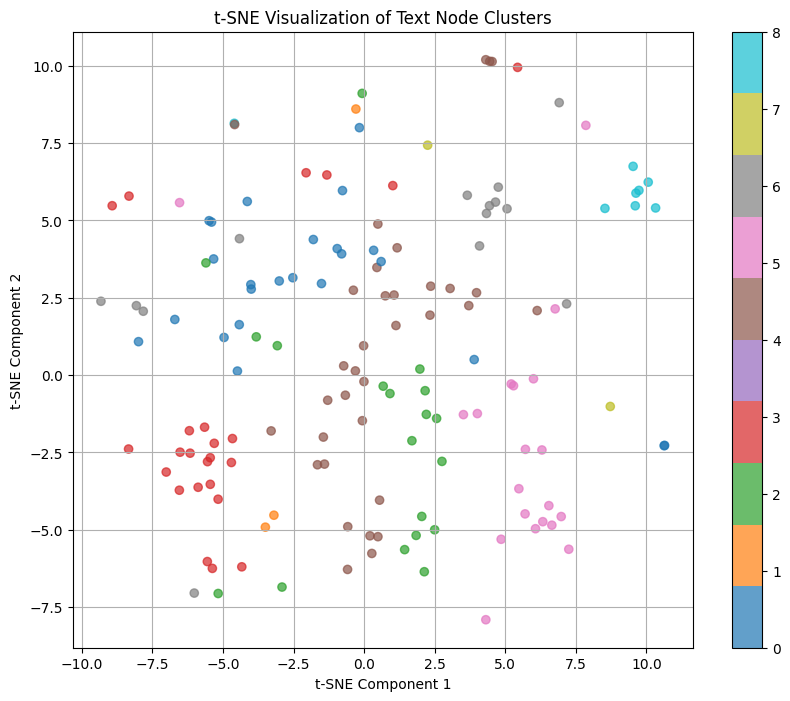

In [46]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_clusters_with_tsne(embeddings, node_to_cluster_mapping):
    """
    Visualize the clustered text nodes using t-SNE.

    Args:
        embeddings (Dict[str, np.ndarray]): Dictionary of text node embeddings.
        node_to_cluster_mapping (Dict[str, int]): Mapping of text nodes to their cluster labels.

    Returns:
        None
    """
    # Convert embeddings and labels to arrays for plotting
    embedding_vectors = np.array(list(embeddings.values()))
    labels = np.array([node_to_cluster_mapping[node] for node in embeddings.keys()])

    # Perform t-SNE dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embedding_vectors)

    # Create a scatter plot of the reduced embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Text Node Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize the clustered text nodes using t-SNE
visualize_clusters_with_tsne(embeddings, node_to_cluster_mapping)



In [74]:
from collections import Counter, defaultdict

def find_most_important_words_per_cluster(inverted_index, node_to_cluster_mapping, top_n=5):
    """
    Identify the most important words for each cluster based on term frequency and importance.

    Args:
        inverted_index (Dict[str, Dict]): The inverted index with word occurrences and importance scores.
        node_to_cluster_mapping (Dict[str, int]): Mapping of text nodes to their cluster labels.
        top_n (int): The number of most important words to return for each cluster.

    Returns:
        Dict[int, List[str]]: A dictionary where each cluster is mapped to its most important words.
    """
    # Initialize a dictionary to store word counts for each cluster
    cluster_word_counts = defaultdict(Counter)

    # Loop through the inverted index to accumulate word counts per cluster
    for word, data in inverted_index.items():
        for doc_id, count in data['occurrences']:
            node_label = f'text_{doc_id}'
            if node_label in node_to_cluster_mapping:
                cluster_id = node_to_cluster_mapping[node_label]
                cluster_word_counts[cluster_id][word] += count * data['importance']

    # Identify the top words for each cluster
    cluster_top_words = {
        cluster_id: [word for word, _ in word_counts.most_common(top_n)]
        for cluster_id, word_counts in cluster_word_counts.items()
    }

    return cluster_top_words

# Find the most important words for each cluster
most_important_words_per_cluster = find_most_important_words_per_cluster(inverted_index, node_to_cluster_mapping, top_n=15)

# Display the most important words for each cluster
for cluster_id, top_words in most_important_words_per_cluster.items():
    print(f"Cluster {cluster_id}: Top Words -> {', '.join(top_words)}")


Cluster 0: Top Words -> relation, oracle, retrieval, disease, similarity, attention, onomatopoeia, extraction, graph, prediction, sketch, writer, script, dependency, model
Cluster 5: Top Words -> font, diffusion, impression, letter, generation, handwriting, character, style, book, automatic, estimation, scoring, virtual, confidence, geometric
Cluster 4: Top Words -> reading, expression, graph, semantic, slide, entity, mathematical, extraction, scene, license, model, question, visual, metric, task
Cluster 2: Top Words -> segmentation, competition, artistic, ancient, line, degraded, wer, detection, chemical, historical, algorithm, scene, semantic, map, charm
Cluster 6: Top Words -> signature, verification, video, shaky, class, attack, real, model, registration, incremental, id, feature, imbalance, identity, principal
Cluster 3: Top Words -> table, chart, detection, dense, structure, annotation, layout, summarization, scene, model, object, sprint, question, performance, multimodal
Cluster

In [85]:
from collections import Counter

# Further expanded predefined categories with associated keywords
categories = {
    "tables": {
        "table", "layout", "graph", "cell", "spreadsheet", "matrix", "grid", "row", "column", "structure",
        "arrangement", "chart", "data table", "table format", "alignment", "tabular", "dataset display", "pivot table",
        "array", "framework", "sequence"
    },
    "classification": {
        "classification", "category", "predict", "label", "classifier", "model", "machine learning", "algorithm", "taxonomy",
        "segmentation", "grouping", "categorization", "sorting", "decision tree", "neural network", "SVM", "clustering",
        "class labels", "supervised learning", "data labeling", "ranking", "binary classification"
    },
    "keyInformationExtraction": {
        "extraction", "task", "key", "information", "field", "retrieval", "data extraction", "summary", "highlight",
        "selection", "detection", "keyword extraction", "text mining", "parsing", "relevance", "information retrieval",
        "entity extraction", "data extraction tool", "feature extraction", "automated extraction", "data field"
    },
    "opticalCharacterRecognition": {
        "recognition", "text", "handwritten", "ocr", "character", "image", "conversion", "scanned", "digitize",
        "text recognition", "printed", "character recognition", "optical reading", "document scanning", "font detection",
        "text extraction", "pdf to text", "pattern recognition", "digitized text", "letter recognition", "text analysis"
    },
    "datasets": {
        "dataset", "data", "competition", "image", "documents", "collection", "samples", "training data", "annotations",
        "resources", "benchmark", "data repository", "data source", "sample set", "research data", "data gathering",
        "test set", "training set", "evaluation data", "open dataset", "data set", "data collection", "dataset sharing"
    },
    "layoutUnderstanding": {
        "document", "layout", "structure", "format", "content", "design", "organization", "visual", "presentation",
        "spatial", "formatting", "document layout", "page design", "arrangement", "visual hierarchy", "sectioning",
        "white space", "document structure", "content formatting", "visual composition", "spatial arrangement",
        "page layout", "template design", "styling"
    },
    "others": set()  # To handle cases where none of the keywords match
}


# Use the most important words for each cluster obtained from previous analysis
cluster_keywords = most_important_words_per_cluster  # Replace with the LDA-generated keywords if you have them

# Function to calculate similarity scores between cluster keywords and category keywords
def calculate_similarity(cluster_keywords, category_keywords):
    overlap = len(set(cluster_keywords) & category_keywords)
    return overlap / len(category_keywords) if category_keywords else 0

# Dictionary to store the best-matching categories for each cluster
cluster_to_category = {}

# Match each cluster to the predefined categories
for cluster_label, keywords in cluster_keywords.items():
    similarity_scores = {category: calculate_similarity(keywords, category_keywords) for category, category_keywords in categories.items()}
    sorted_categories = sorted(similarity_scores, key=similarity_scores.get, reverse=True)

    # Take the top 3 categories if they have some similarity, otherwise default to "others"
    top_categories = sorted_categories[:3] if similarity_scores[sorted_categories[0]] > 0 else ["others"]
    cluster_to_category[cluster_label] = top_categories

# Display the best matching categories for each cluster
for cluster_label, top_categories in cluster_to_category.items():
    print(f'Cluster {cluster_label}: Best Matching Categories - {", ".join(top_categories)}')


Cluster 0: Best Matching Categories - keyInformationExtraction, tables, classification
Cluster 5: Best Matching Categories - opticalCharacterRecognition, tables, classification
Cluster 4: Best Matching Categories - keyInformationExtraction, tables, classification
Cluster 2: Best Matching Categories - classification, keyInformationExtraction, datasets
Cluster 6: Best Matching Categories - classification, tables, keyInformationExtraction
Cluster 3: Best Matching Categories - tables, layoutUnderstanding, keyInformationExtraction
Cluster 1: Best Matching Categories - layoutUnderstanding, tables, classification
Cluster 8: Best Matching Categories - classification, tables, keyInformationExtraction
Cluster 7: Best Matching Categories - classification, keyInformationExtraction, opticalCharacterRecognition


In [86]:
def match_texts_to_single_category(node_to_cluster_mapping, cluster_to_category):
    """
    Match each clustered text node to its most relevant category based on the cluster-to-category mapping.

    Args:
        node_to_cluster_mapping (Dict[str, int]): Mapping of text nodes to their cluster labels.
        cluster_to_category (Dict[int, List[str]]): Best matching categories for each cluster.

    Returns:
        Dict[str, str]: A dictionary mapping each text node to its assigned category.
    """
    text_to_category_mapping = {}

    # Assign each text node to the most relevant category of its corresponding cluster
    for text_node, cluster_label in node_to_cluster_mapping.items():
        # Get the first (most relevant) category for the cluster
        assigned_category = cluster_to_category.get(cluster_label, ["others"])[0]
        text_to_category_mapping[text_node] = assigned_category

    return text_to_category_mapping

# Match each clustered text node to its most relevant category
text_to_category_mapping = match_texts_to_single_category(node_to_cluster_mapping, cluster_to_category)

# Display the category assignment for each text node
for text_node, assigned_category in list(text_to_category_mapping.items())[:10]:  # Displaying the first 10 entries for brevity
    print(f'Text Node: {text_node}, Assigned Category: {assigned_category}')


Text Node: text_29, Assigned Category: keyInformationExtraction
Text Node: text_52, Assigned Category: keyInformationExtraction
Text Node: text_55, Assigned Category: keyInformationExtraction
Text Node: text_122, Assigned Category: opticalCharacterRecognition
Text Node: text_7, Assigned Category: keyInformationExtraction
Text Node: text_90, Assigned Category: classification
Text Node: text_18, Assigned Category: keyInformationExtraction
Text Node: text_103, Assigned Category: classification
Text Node: text_15, Assigned Category: classification
Text Node: text_24, Assigned Category: keyInformationExtraction


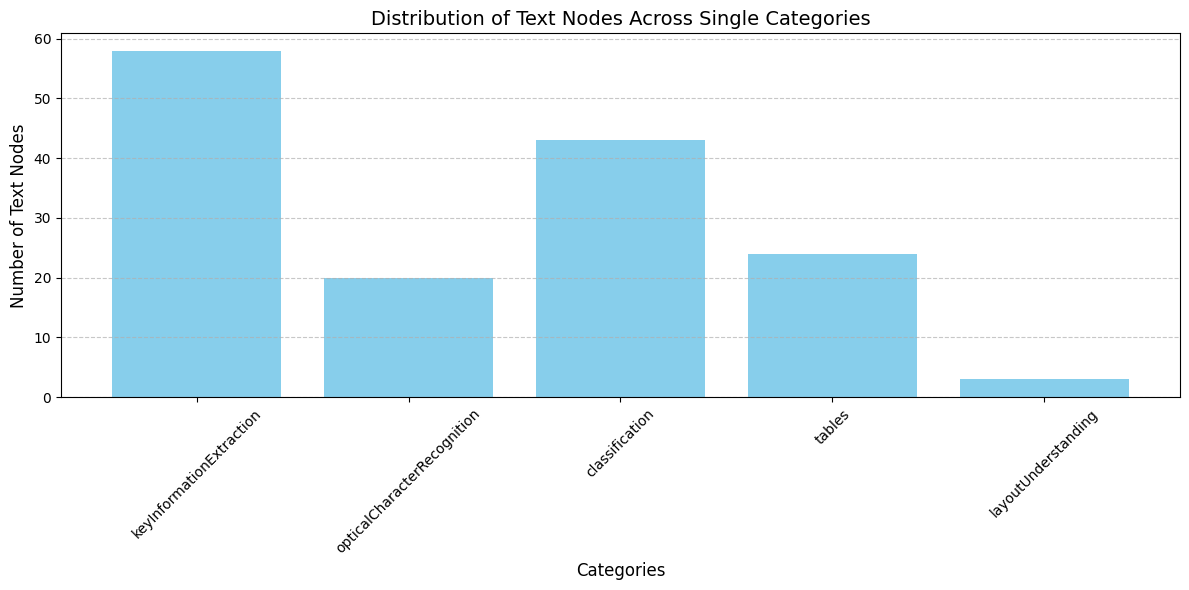

In [87]:
import matplotlib.pyplot as plt
from collections import Counter

def visualize_single_category_distribution(text_to_category_mapping):
    """
    Visualize the distribution of text nodes across categories using a bar chart.

    Args:
        text_to_category_mapping (Dict[str, str]): Mapping of text nodes to their assigned single category.
    """
    # Count the occurrences of each category in the text node mapping
    category_counts = Counter(text_to_category_mapping.values())

    # Create the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
    plt.title('Distribution of Text Nodes Across Single Categories', fontsize=14)
    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Number of Text Nodes', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Visualize the single category distribution using the bar chart
visualize_single_category_distribution(text_to_category_mapping)


In [88]:
import json
from collections import defaultdict

# Load the JSON file with document information
input_json_path = './extracted_information.json'

with open(input_json_path, 'r', encoding='utf-8') as file:
    extracted_info = json.load(file)

def build_combined_json_structure(text_to_category_mapping, extracted_info):
    """
    Combine the clustered text information with the data from the extracted information JSON file.

    Args:
        text_to_category_mapping (Dict[str, str]): Mapping of text nodes to their assigned single category.
        extracted_info (Dict): The JSON data containing document details.

    Returns:
        Dict: A dictionary with categories as keys and a list of text information as values.
    """
    # Initialize a dictionary to store the final JSON structure
    category_structure = defaultdict(list)

    # Loop through each entry in the extracted information and match it with the text node
    for entry in extracted_info['tables']:
        doc_id = entry['ID']
        title = entry['Title']
        authors = entry['Authors']
        original_file_name = f"paper_{doc_id}.pdf"  # Assuming file names are in this format

        # Build the entry for the JSON structure
        text_entry = {"originalFileName": original_file_name, "title": title, "authors": authors}

        # Get the text node ID
        text_node_id = f"text_{doc_id}"

        # Get the assigned single category for this text node
        assigned_category = text_to_category_mapping.get(text_node_id, "others")

        # Add the entry to the respective category in the JSON structure
        category_structure[assigned_category].append(text_entry)

    return category_structure

# Build the combined JSON structure using the extracted information and text-to-category mapping
combined_json_structure = build_combined_json_structure(text_to_category_mapping, extracted_info)

# Display the resulting JSON structure for verification
print(json.dumps(combined_json_structure, indent=4))

# Save the combined JSON structure to a file
output_json_path = './categorized_documents.json'

with open(output_json_path, 'w') as json_file:
    json.dump(combined_json_structure, json_file, indent=4)

print(f"JSON file saved successfully to {output_json_path}")


{
    "classification": [
        {
            "originalFileName": "paper_4.pdf",
            "title": "SAGHOG: Self-Supervised Autoencoder for Generating HOG Features for Writer Retrieval",
            "authors": [
                "Robert Sablatnig",
                "Marco Peer",
                "Florian Kleber"
            ]
        },
        {
            "originalFileName": "paper_22.pdf",
            "title": "CREPE: Coordinate-Aware End-to-End Document Parser",
            "authors": [
                "Ryota Nakao",
                "DongHyun Kim",
                "Youngmin Baek",
                "Moon Bin Yim",
                "Yamato Okamoto",
                "Bado Lee",
                "Geewook Kim",
                "Seunghyun Park"
            ]
        },
        {
            "originalFileName": "paper_25.pdf",
            "title": "A Hybrid Approach for Document Layout Analysis in Document images",
            "authors": [
                "Tahira Shehzadi",
              